# Copernicus Climate Data Store (CDS) API
- CDS documentation: https://confluence.ecmwf.int/display/CKB/Climate+Data+Store+%28CDS%29+documentation
- Developer and API documentation: https://cds.climate.copernicus.eu/toolbox/doc/index.html
- Use bboxfinder tool to select a suitable geographic bounding box: http://bboxfinder.com

In [774]:
from pathlib import Path
from itertools import product
from math import radians
import json

import requests
import cdsapi
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.metrics.pairwise import haversine_distances

In [98]:
# Directory where data files will be downloaded
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

In [99]:
data_path

PosixPath('/Users/brand/my_code/meteoviz/course_project/data')

In [100]:
# Make sure api key is in dot file in home dir
cds = cdsapi.Client()
print(cds.url)
print(cds.verify)
print(cds.timeout)

https://cds.climate.copernicus.eu/api/v2
True
60


#### Forming the API request
- From the documentation: "We strongly suggest to construct CDS API requests by using the CDS web interface of the relevant dataset and using the 'Show API request' button to get the code."
    - hourly data single levels: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview
    - hourly data pressure levels: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=overview

#### Suitable geographic bounding box that contains all of Germany
- Box coordinates (long,lat): 4.218,46.073,17.028,56.377
- CDS needs it in North(0 to 90), West(0 to -180), South(0 to -90), East (0 to 180). Default: global
    - That's `[56.38, 4.22, 46.07, 17.03]`

#### Data size and request duration
- One year of hourly 100m and 10m wind components (4 variables) for above bounding box is 150 MB
- API call took 17 minutes from queued, running to completed

#### Variables of interest
- `100m_u-component_of_wind`, `100m_v-component_of_wind` and 10m components have units `m s**-1` and  are single level, instantanous parameters
- instantaneous: Although they are valid at the specified time, and NOT an average over the model time step, such parameters cannot represent variability on short time scales. This arises because the model values are a grid box average, without variability on spatial scales smaller than the grid

In [50]:
# # Get hourly 10m and 100m wind components for one year
# cds.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'format': 'netcdf',
#         'variable': [
#             '100m_u_component_of_wind', '100m_v_component_of_wind', '10m_u_component_of_wind',
#             '10m_v_component_of_wind',
#         ],
#         'year': '2021',
#         'month': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': [
#             '00:00', '01:00', '02:00',
#             '03:00', '04:00', '05:00',
#             '06:00', '07:00', '08:00',
#             '09:00', '10:00', '11:00',
#             '12:00', '13:00', '14:00',
#             '15:00', '16:00', '17:00',
#             '18:00', '19:00', '20:00',
#             '21:00', '22:00', '23:00',
#         ],
#         'area': [
#             56.38, 4.22, 46.07,
#             17.03,
#         ],
#     },
#     str(data_path.joinpath('wind_data_2021.nc')))

2023-09-04 00:27:00,872 INFO Welcome to the CDS
2023-09-04 00:27:00,873 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-09-04 00:27:01,048 INFO Request is queued
2023-09-04 00:27:02,186 INFO Request is running
2023-09-04 00:45:21,895 INFO Request is completed
2023-09-04 00:45:21,896 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data6/adaptor.mars.internal-1693780956.9471045-19216-15-4d4e8e02-b91a-4902-b9fe-ab2b33e28aaa.nc to /Users/brand/my_code/meteoviz/course_project/data/wind_data_2021.nc (146M)
2023-09-04 00:45:31,129 INFO Download rate 15.8M/s                          


Result(content_length=153091980,content_type=application/x-netcdf,location=https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data6/adaptor.mars.internal-1693780956.9471045-19216-15-4d4e8e02-b91a-4902-b9fe-ab2b33e28aaa.nc)

#### Note
- Is the projection of the grid: equal-area EPSG:3035 projection? 
- Grid resolution should be 30km x 30km
    - ERA5 data is referenced in the horizontal with respect to the WGS84 ellipse (which defines the major/minor axes) and in the vertical it is referenced to the EGM96 geoid over land but over ocean it is referenced to mean sea level, with the approximation that this is assumed to be coincident with the geoid
    - The native grid is the reduced Gaussian grid N320

#### Reading and writing netCDF files in Xarray
- https://docs.xarray.dev/en/stable/user-guide/io.html

-----

## Load NetCDF data into Xarray 
- Note: The grid points are the same for subsequent API calls on the same region!

In [24]:
# Load the NetCDF file using Xarray
ds = xr.open_dataset(data_path.joinpath('wind_data.nc'))

In [51]:
# Load the NetCDF file using Xarray
ds_2021 = xr.open_dataset(data_path.joinpath('wind_data_2021.nc'))

##### Check that the lat, lon coords are the same as previous dataset 

In [176]:
# Create 2D arrays of lat, lon pairs; shape (2184, 2)
ds_coords = np.array(list(product(ds.latitude.values, ds.longitude.values)))
ds_2021_coords = np.array(list(product(ds_2021.latitude.values, ds_2021.longitude.values)))

# Test that they have same shape and elements
np.array_equal(ds_coords, ds_2021_coords)

True

In [25]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 52, latitude: 42, time: 8760)
Coordinates:
  * longitude  (longitude) float32 4.22 4.47 4.72 4.97 ... 16.47 16.72 16.97
  * latitude   (latitude) float32 56.32 56.07 55.82 55.57 ... 46.57 46.32 46.07
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
Data variables:
    u100       (time, latitude, longitude) float32 ...
    v100       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-27 18:02:49 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [52]:
ds_2021

<xarray.Dataset>
Dimensions:    (longitude: 52, latitude: 42, time: 8760)
Coordinates:
  * longitude  (longitude) float32 4.22 4.47 4.72 4.97 ... 16.47 16.72 16.97
  * latitude   (latitude) float32 56.32 56.07 55.82 55.57 ... 46.57 46.32 46.07
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-12-31T23:00:00
Data variables:
    u100       (time, latitude, longitude) float32 ...
    v100       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-03 22:44:25 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [27]:
# Plot the first time step and first variable
data_var = list(ds.data_vars)[0]
data = ds[data_var].isel(time=0)

In [46]:
data_var

'u100'

In [29]:
data

<xarray.DataArray 'u100' (latitude: 42, longitude: 52)>
[2184 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 4.22 4.47 4.72 4.97 ... 16.47 16.72 16.97
  * latitude   (latitude) float32 56.32 56.07 55.82 55.57 ... 46.57 46.32 46.07
    time       datetime64[ns] 2022-01-01
Attributes:
    units:      m s**-1
    long_name:  100 metre U wind component

In [90]:
# Extract latitude and longitude data
lat = ds.latitude.values
lon = ds.longitude.values

In [31]:
lat

array([56.32, 56.07, 55.82, 55.57, 55.32, 55.07, 54.82, 54.57, 54.32,
       54.07, 53.82, 53.57, 53.32, 53.07, 52.82, 52.57, 52.32, 52.07,
       51.82, 51.57, 51.32, 51.07, 50.82, 50.57, 50.32, 50.07, 49.82,
       49.57, 49.32, 49.07, 48.82, 48.57, 48.32, 48.07, 47.82, 47.57,
       47.32, 47.07, 46.82, 46.57, 46.32, 46.07], dtype=float32)

In [387]:
# Create meshgrid for lat and lon values
lon, lat = np.meshgrid(lon, lat)

[56.38, 4.22, 46.07, 17.03]

In [389]:
lon.shape

(42, 52)

### Plotting the grid points over Germany and validating the haversine calculation works

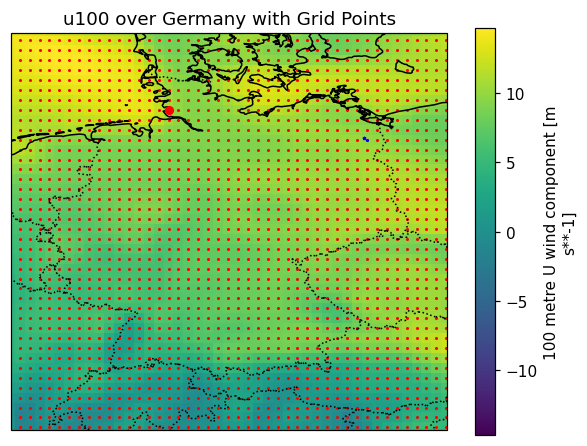

In [535]:
# Create a figure and axis with cartopy projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([5, 16, 46, 56])  # Extent for Germany

# Plot the data
data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=True)

# Plot the grid points
ax.scatter(lon, lat, color='red', s=1, transform=ccrs.PlateCarree())

# Haversine validation ----------
# Plot test turbine location
ax.scatter([13.901308,], [53.350347,], color='blue', s=3, transform=ccrs.PlateCarree(), marker='*', zorder=2)
# Plot turbine's closest grid point based on results of haversine calcluation
ax.scatter([13.97,], [53.32,], color='blue', s=1, transform=ccrs.PlateCarree(), zorder=2)
# Hottest grid point representing 458 turbines
ax.scatter([8.97,], [54.07,], color='red', s=25, transform=ccrs.PlateCarree(), zorder=2)


# Add map features for context
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.set_title(f"{data_var} over Germany with Grid Points")

plt.show()

-----

## Calculating the closest grid point for each turbine
- "When you download ERA5 data, the grid geometry of your output data depends on the selected data format:
    - If you request the data in the native GRIB format it is delivered with the above grid geometry.
    - If you request the data in NetCDF format, _it is automatically converted and interpolated from the above grids to a regular lat/lon grid_."
        - "If you are using a NetCDF file, then your data is in EPSG:4326 geographic coordinates (aka WGS84 projection)"
    - https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference
- Three possible methods to calculate the nearest grid point
    - Use Haversine distance?
        - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html
        - "determine Great Circle distances between locations (good if your data is in lat/lon format)"
    - KDTree
        - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html
    - Nearest-neighbor interpolation
        - https://en.wikipedia.org/wiki/Nearest-neighbor_interpolation
        - https://stackoverflow.com/questions/30873844/identifying-the-nearest-grid-point
        - Scipy `scipy.interpolate.RegularGridInterpolator`: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RegularGridInterpolator.html\
- Projected coordinate system (or planar, grid)
    - A standardized cartesian coordinate system that models the Earth (or more commonly, a large region thereof) as a plane, measuring locations from an arbitrary origin point along x and y axes more or less aligned with the cardinal directions

In [121]:
ds.longitude.values

array([ 4.22,  4.47,  4.72,  4.97,  5.22,  5.47,  5.72,  5.97,  6.22,
        6.47,  6.72,  6.97,  7.22,  7.47,  7.72,  7.97,  8.22,  8.47,
        8.72,  8.97,  9.22,  9.47,  9.72,  9.97, 10.22, 10.47, 10.72,
       10.97, 11.22, 11.47, 11.72, 11.97, 12.22, 12.47, 12.72, 12.97,
       13.22, 13.47, 13.72, 13.97, 14.22, 14.47, 14.72, 14.97, 15.22,
       15.47, 15.72, 15.97, 16.22, 16.47, 16.72, 16.97], dtype=float32)

In [68]:
ds.latitude.values

array([56.32, 56.07, 55.82, 55.57, 55.32, 55.07, 54.82, 54.57, 54.32,
       54.07, 53.82, 53.57, 53.32, 53.07, 52.82, 52.57, 52.32, 52.07,
       51.82, 51.57, 51.32, 51.07, 50.82, 50.57, 50.32, 50.07, 49.82,
       49.57, 49.32, 49.07, 48.82, 48.57, 48.32, 48.07, 47.82, 47.57,
       47.32, 47.07, 46.82, 46.57, 46.32, 46.07], dtype=float32)

In [81]:
# Using itertools' product to get all 2,184 coordinate (lat, lon) pairs
list(product(ds.longitude.values, ds.latitude.values))[:5]

[(4.22, 56.32), (4.22, 56.07), (4.22, 55.82), (4.22, 55.57), (4.22, 55.32)]

In [82]:
len(list(product(ds.longitude.values, ds.latitude.values)))

2184

-----

## Test haversine equation
- The first coordinate of each point is assumed to be the latitude, the second is the longitude, given in radians
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html

In [403]:
# Great circle distance should be 474km
# Must use order lat, lon!
bonn = [50.73, 7.09]
berlin = [52.52, 13.41]

# Convert decimal degrees to radians
bonn_in_radians = [radians(decimal_degree) for decimal_degree in bonn]
berlin_in_radians = [radians(decimal_degree) for decimal_degree in berlin]

# Calculate haversine and multiply by Earth radius in km to get distance in km (or radius in m for distance in m)
result = haversine_distances([bonn_in_radians, berlin_in_radians]) * 6371
result

array([[  0.        , 479.31408256],
       [479.31408256,   0.        ]])

In [404]:
# Add additional points
bsas = [-34.83333, -58.5166646]
paris = [49.0083899664, 2.53844117956]
bsas_in_radians = [radians(decimal_degree) for decimal_degree in bsas]
paris_in_radians = [radians(decimal_degree) for decimal_degree in paris]

In [405]:
[bonn_in_radians]

[[0.8854055295367234, 0.12374384396639797]]

#### Calculate distances from X using an array of locations in the 2D array Y

In [406]:
# 2D array (or list inside list) of the point of interest; this will be the turbine location! 
X = [bonn_in_radians]
# The three other locations (this will be the grid points)
Y = [berlin_in_radians, bsas_in_radians, paris_in_radians]

# Calculate distances from Bonn (the point of interest) to the other locations
result = haversine_distances(X, Y)
result_in_km = result * 6371
result_in_km

array([[  479.31408256, 11470.55838348,   378.13054497]])

In [413]:
# Get minimum distance; this will be the closest grid point
closest_distance = result_in_km.min()

# Index of closest distance
idx_closest = np.argmin(result_in_km)

print(f'Distance: {closest_distance} km')
print(idx_closest)
print(grid_points[idx_closest])

Distance: 378.13054497006664 km
2
(56.32, 4.72)


----

## Calculating the nearest grid point for every turbine in dataset
- And adding the nearest grid point as a new column

### Read in turbine data

In [566]:
# Read in turbine data
df = pd.read_pickle(data_push_path / 'df_turbines_knn_wrangled.pkl')

In [733]:
# Cartesian product of grid latitude and longitude values
grid_points = tuple(product(ds.latitude.values, ds.longitude.values))

# Nested list comprehension to convert each decimal degree to radians, creating 2D matrix shape (2184, 2)
grid_points_radians = np.array([[radians(decimal_degree) for decimal_degree in decimal_degree_pair] for decimal_degree_pair in grid_points])

#### Custom function to calculate haversine distances and get nearest grid point

In [570]:
# This is my most stable func so far
def calc_nearest_grid_point(row, grid_points):
    # turbine lat, lon decimal degrees in list
    turbine_lat_lon = [row.Breitengrad, row.Laengengrad]
    # convert decimal degrees to radians and reshape to 2D array
    turbine_lat_lon_radians = np.array([[radians(decimal_degree) for decimal_degree in turbine_lat_lon]])
    
    # Nested list comprehension to convert each grid point's decimal degree to radians, creating 2D matrix shape (2184, 2)
    grid_points_radians = np.array([[radians(decimal_degree) for decimal_degree in decimal_degree_pair] for decimal_degree_pair in grid_points])
    
    # calculate haversine distances of all grid points from turbine
    # X is the turbine coords in radians as 2D matrix; Y is grid points in radians as 2D matrix
    distances = haversine_distances(turbine_lat_lon_radians, grid_points_radians)
    # multiply by Earth radius in km (6371 km) to get distance in km (or radius in m for distance in m)
    distances_in_km = distances * 6371
    
    # Get shortest distance; this is the closest grid point's distance in km
    shortest_distance = distances_in_km.min()
    # Index of shortest distance
    idx_closest = np.argmin(distances_in_km)
    # Get lat, lon coords of closest grid point by indexing
    nearest_grid_point_to_turbine = grid_points[idx_closest]
    
    # row['nearest_grid_point'] = nearest_grid_point_to_turbine
    
    return nearest_grid_point_to_turbine

In [571]:
# takes c. 1 minute to run
# df['nearest_grid_point'] = df[['Breitengrad', 'Laengengrad']].apply(calc_nearest_grid_point, grid_points=grid_points, axis=1)

In [574]:
# df.loc[10178, ['Breitengrad', 'Laengengrad', 'nearest_grid_point']]

In [575]:
df[['Breitengrad', 'Laengengrad', 'nearest_grid_point']].sample(4)

,Breitengrad,Laengengrad,nearest_grid_point
19507,52.000143,12.839271,"(52.07, 12.72)"
24366,54.034055,12.189490,"(54.07, 12.22)"
24858,51.776701,8.147305,"(51.82, 8.22)"
25776,51.104760,6.430310,"(51.07, 6.47)"


#### Save df as pickle object to save progress

In [498]:
# save df to data to push dir so it lands in GitHub repo
# df.to_pickle(data_push_path / 'df_turbines_knn_blades_haversine.pkl')

-----

### Get array of grid points that are unused
- 2,184 unique coordinate pairs in CDS
- 758 unique used by turbines
- 1,426 grid points are unused

In [738]:
# 2,184 coordinate pairs from CDS data bounding box
# 42 latitude x 52 longitude = 2,184
grid_points_set = set(grid_points)

In [740]:
# create set of tuples
# set(zip(grid_points_array.T[0], grid_points_array.T[1]))

In [648]:
# Only 758 are nearest points for turbines
# 1,426 grid points are unused out of the 2,184
# 1D array of unique tuples
used_grid_points = np.unique(df['nearest_grid_point'].to_numpy())
used_grid_points.shape

(758,)

#### I can use this set of unused grid points to reduce the xarray dataset size

In [742]:
# Set of used grid points; also 758 since all are unique
# I can use these to reduce xarray dataset size! 

# cast array as set
grid_points_used_set = set(used_grid_points)

In [746]:
# Set of 1,426 unused grid points
unused_grid_points = grid_points_set.difference(grid_points_used_set)

In [749]:
len(grid_points_set.union(grid_points_used_set))

2184

In [745]:
# vertical stack the used grid points and reshape
# used_grid_points_2d = np.vstack(np.unique(df['nearest_grid_point'].to_numpy())).reshape(758, 2)
# used_grid_points_2d

In [642]:
# access the 2184 latitudes
np.array(grid_points)[:,0]

array([56.32, 56.32, 56.32, ..., 46.07, 46.07, 46.07], dtype=float32)

In [683]:
# access the 2184 longitudes
np.array(grid_points)[:,1]

array([ 4.22,  4.47,  4.72, ..., 16.47, 16.72, 16.97], dtype=float32)

-----

## Add elevation data for each of the 758 used grid points
- Use Open-Elevation. It's a free and open-source alternative to the Google Elevation API and similar offerings
    - https://github.com/Jorl17/open-elevation
    - https://open-elevation.com/

#### Function that fetches elevation data from Open-Elevation

In [900]:
url_endpoint = "https://api.open-elevation.com/api/v1/lookup"

def fetch_elevation_data(coordinates):
    """
    Fetch elevations for list of coordinates in lat, lon tuples
    """
    # Format coordinates according to Open-Elevation requirements
    # Lat and lons are type float32 (not JSON serializable); cast to Python float64
    grid_point_locations = [{"latitude": float(lat), "longitude": float(lon)} for lat, lon in coordinates]
    # Make POST request
    response = requests.post(url_endpoint, json={"locations": grid_point_locations})
    if response.status_code == 200:  
        # Decode JSON response object to Python dict
        datadict = response.json()
        # Return decoded object as dict
        return datadict
    else:
        return f'Request failed'

In [837]:
# list of lat,lon tuples -> (47.07, 5.72)
# Careful: this gives values of type numpy.float32 with is not JSON serializable!
coordinates_needing_elevation = used_grid_points.tolist()

#### Call function and fetch data via API

In [838]:
# Call function to fetch elevation data
# elevation_datadict = fetch_elevation_data(coordinates_needing_elevation)

##### Construct dataframe using response data

In [887]:
# load datadict results into dataframe
df_elevations = pd.DataFrame(elevation_datadict['results'])
df_elevations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758 entries, 0 to 757
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   758 non-null    float64
 1   longitude  758 non-null    float64
 2   elevation  758 non-null    float64
dtypes: float64(3)
memory usage: 17.9 KB


In [888]:
# create new column with coordinates as tuples of lat, lon casted as float32 to match dtype in df
df_elevations['nearest_grid_point'] = df_elevations.apply(lambda row: (np.float32(row.latitude), np.float32(row.longitude)), axis=1)
df_elevations.head()

,latitude,longitude,elevation,nearest_grid_point
0,47.07,5.72,256.0,"(47.07, 5.72)"
1,47.57,7.72,506.0,"(47.57, 7.72)"
2,47.57,7.97,435.0,"(47.57, 7.97)"
3,47.57,10.22,833.0,"(47.57, 10.22)"
4,47.57,10.72,798.0,"(47.57, 10.72)"


In [899]:
# tuple objects are equal
df_elevations['nearest_grid_point'].isin(df['nearest_grid_point']).value_counts()

nearest_grid_point
True    758
Name: count, dtype: int64

In [892]:
type(df['nearest_grid_point'].to_list()[0][0])

numpy.float32

In [893]:
type(df_elevations['nearest_grid_point'].to_list()[0][0])

numpy.float32

In [898]:
# Check that there's no difference between the two sets
elevation_set = set(df_elevations['nearest_grid_point'].to_list())
print(elevation_set.difference(grid_points_used_set))
print(grid_points_used_set.difference(elevation_set))

set()
set()


#### Merge elevation into main `df` using key `nearest_grid_point`

----

## Periods/intervals during which turbine is operational 

In [499]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30645 entries, 0 to 30644
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   EinheitMastrNummer                     30645 non-null  object        
 1   DatumLetzteAktualisierung              30645 non-null  datetime64[ns]
 2   Bundesland                             30645 non-null  object        
 3   Postleitzahl                           30645 non-null  int64         
 4   Ort                                    30645 non-null  object        
 5   Laengengrad                            30645 non-null  float64       
 6   Breitengrad                            30645 non-null  float64       
 7   Registrierungsdatum                    30645 non-null  datetime64[ns]
 8   Inbetriebnahmedatum                    30645 non-null  datetime64[ns]
 9   EinheitBetriebsstatus                  30645 non-null  object

In [503]:
date_columns = [
    'Inbetriebnahmedatum', 
    'DatumEndgueltigeStilllegung',
    'DatumBeginnVoruebergehendeStilllegung',
    'DatumWiederaufnahmeBetrieb',
]

In [519]:
df[date_columns][(df['DatumEndgueltigeStilllegung'].notna()) & (df['DatumBeginnVoruebergehendeStilllegung'].notna())]

,Inbetriebnahmedatum,DatumEndgueltigeStilllegung,DatumBeginnVoruebergehendeStilllegung,DatumWiederaufnahmeBetrieb
8812,2010-03-25,2020-07-15,2020-07-14,NaT
8818,2010-03-23,2020-07-14,2020-07-13,NaT
8824,2010-03-18,2020-07-25,2020-07-24,NaT
8841,2010-03-19,2020-05-29,2020-05-28,NaT
8842,2010-03-22,2020-07-23,2020-07-22,NaT
8845,2010-03-19,2020-07-17,2020-07-16,NaT
8878,2003-12-06,2020-08-11,2020-08-10,NaT
8955,2009-09-25,2020-08-19,2020-08-18,NaT
8958,2009-09-17,2020-06-25,2020-06-24,NaT
8960,2009-09-25,2020-06-23,2020-06-22,NaT


In [524]:
# Turbines that went into operation and were decommissioned without temporary shut-downs
df[date_columns][(df['DatumEndgueltigeStilllegung'].notna()) & (df['DatumBeginnVoruebergehendeStilllegung'].isna()) &
                (df['DatumWiederaufnahmeBetrieb'].isna())]

,Inbetriebnahmedatum,DatumEndgueltigeStilllegung,DatumBeginnVoruebergehendeStilllegung,DatumWiederaufnahmeBetrieb
26,2000-08-03,2021-03-01,NaT,NaT
27,2000-08-04,2021-03-01,NaT,NaT
28,2000-08-03,2021-03-01,NaT,NaT
29,2000-08-09,2021-03-01,NaT,NaT
30,2000-08-07,2021-03-01,NaT,NaT
...,...,...,...,...
30336,2012-06-25,2019-02-15,NaT,NaT
30476,2022-05-27,2023-05-01,NaT,NaT
30485,2022-03-01,2022-04-26,NaT,NaT
30543,2021-05-14,2022-05-16,NaT,NaT


In [516]:
pd.Period('2022', freq='A').start_time

Timestamp('2022-01-01 00:00:00')

In [517]:
pd.Period('2022', freq='A').end_time

Timestamp('2022-12-31 23:59:59.999999999')